In [ ]:
import numpy as np
import pandas as pd

import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_full.csv")
df.head(10)

,ID,Price,Price per sqm,Rooms,Area_total,Kitchen_area,Storeys,District ID,Latitude,Longitude,...,distance_to_nearest_metro_stations_m,sports_centers_count,supermarkets_count,schools_count,kindergartens_count,cafes_restaurants_count,public_transport_count,distance_to_nearest_woods_parks_m,distance_to_nearest_water_reservoirs_m,Floor
0,1846640995.00,2914538.00,45551.00,1.00,64.00,18.00,25.00,10026800,50.38,30.54,...,3192.10,1,2,0,2,3,2,214.20,356.60,22
1,1908757932.00,5620894.00,61081.00,3.00,92.00,12.00,24.00,10026800,50.38,30.54,...,3214.30,1,1,1,2,2,1,208.10,375.00,19
2,1902533750.00,3580718.00,44635.00,2.00,80.20,11.60,25.00,10026800,50.38,30.54,...,2983.40,0,2,0,1,3,2,249.60,240.70,24
3,1778665799.00,2456539.00,48174.00,1.00,51.00,12.00,25.00,10026800,50.38,30.54,...,2619.10,0,0,0,0,0,0,143.10,441.30,19
4,1726124181.00,1207452.00,31103.00,1.00,38.80,13.60,23.00,10026800,50.38,30.54,...,3190.30,1,2,0,1,3,2,249.00,368.80,17
5,1005653909.00,3955444.00,43011.00,3.00,92.00,11.20,24.00,10026800,50.38,30.54,...,3192.10,1,2,0,2,3,2,214.20,356.60,8
6,1980451746.00,3539082.00,41637.00,2.00,85.00,13.00,23.00,10026800,50.38,30.54,...,3128.40,1,3,0,1,3,3,308.60,370.00,22
7,1482457382.00,2452376.00,37140.00,3.00,66.00,7.20,10.00,10026800,50.39,30.55,...,1714.40,0,0,0,0,0,0,654.80,1340.10,1
8,1941193144.00,3497445.00,47924.00,2.00,73.00,12.00,24.00,10026800,50.38,30.54,...,2983.40,0,2,0,1,3,2,249.60,240.70,1
9,1875529363.00,2081813.00,69866.00,1.00,29.80,13.00,27.00,10026800,50.38,30.54,...,2970.90,0,2,0,1,3,2,204.70,197.30,27


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


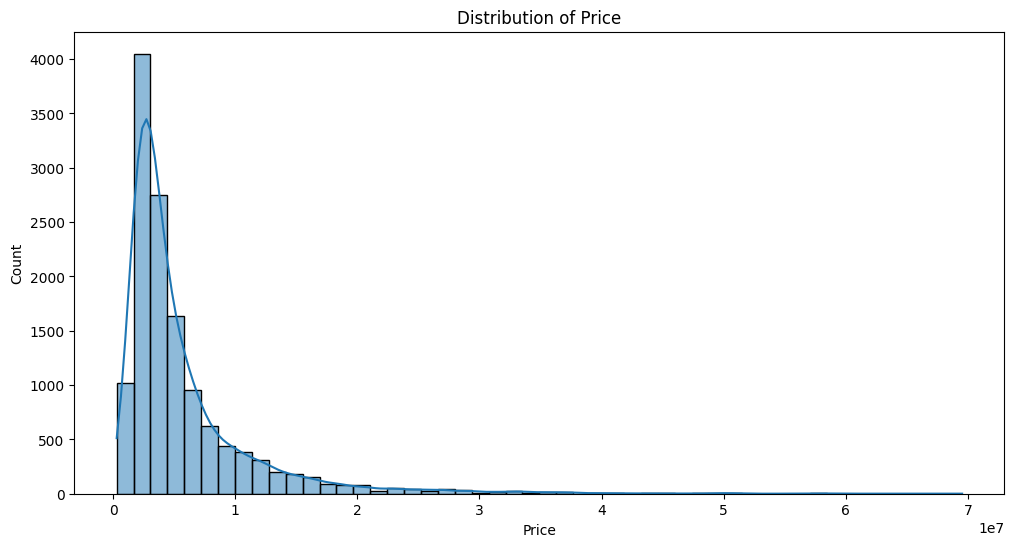

count    1.333000e+04
mean     5.713281e+06
std      5.777227e+06
min      2.914540e+05
25%      2.477357e+06
50%      3.726445e+06
75%      6.573021e+06
max      6.953254e+07
Name: Price, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='Price', kde=True, bins=50)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')

plt.show()

# Print summary statistics
print(df['Price'].describe())

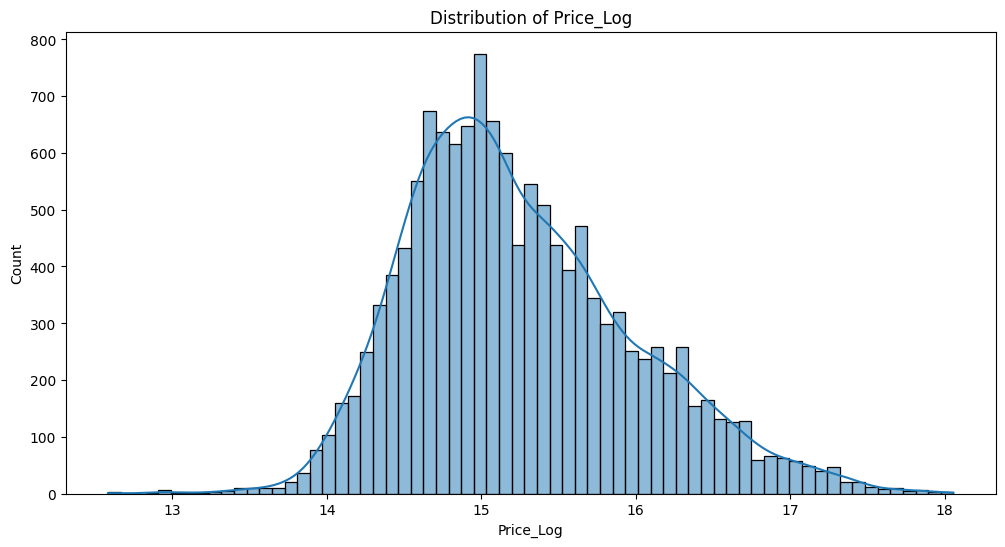

count    13330.000000
mean        15.249822
std          0.735416
min         12.582641
25%         14.722703
50%         15.130966
75%         15.698483
max         18.057305
Name: Log_Price, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='Log_Price', kde=True)
plt.title('Distribution of Price_Log')
plt.xlabel('Price_Log')
plt.ylabel('Count')

plt.show()

# Print summary statistics
print(df['Log_Price'].describe())

Lets apply baseline model and also linear regression to the Log_Price as target

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Define target column and grouping features
target_column = 'Price'  # Use original Price
district_column = 'District ID'
rooms_column = 'Rooms'
area_column = 'Area_total'

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics
mae_original_list = []
mape_list = []

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # Split into train and test sets with .copy() to avoid SettingWithCopyWarning
    train_data = df.iloc[train_index].copy()
    test_data = df.iloc[test_index].copy()

    # Step 1: Calculate the mean Price grouped by District ID and Rooms using training data
    mean_price = (
        train_data.groupby([district_column, rooms_column])[target_column]
        .mean()
        .reset_index()
        .rename(columns={target_column: 'Mean_Price'})
    )

    # Step 2: Calculate the mean Area_total grouped by District ID and Rooms using training data
    mean_area = (
        train_data.groupby([district_column, rooms_column])[area_column]
        .mean()
        .reset_index()
        .rename(columns={area_column: 'Mean_Area'})
    )

    # Merge mean_price and mean_area to compute Price per Sqm
    mean_group = mean_price.merge(mean_area, on=[district_column, rooms_column])

    # Step 3: Calculate Price per Sqm for each group
    mean_group['Price_per_Sqm'] = mean_group['Mean_Price'] / mean_group['Mean_Area']

    # Step 4: Merge Price_per_Sqm into test set based on District ID and Rooms
    test_data = test_data.merge(mean_group[[district_column, rooms_column, 'Price_per_Sqm']],
                                on=[district_column, rooms_column],
                                how='left')

    # Handle missing groups by imputing with the overall Price per Sqm from training data
    overall_price_per_sqm = train_data[target_column].sum() / train_data[area_column].sum()
    test_data['Price_per_Sqm'] = test_data['Price_per_Sqm'].fillna(overall_price_per_sqm)

    # Predict Price in the test set
    test_data['Predicted Price'] = test_data['Price_per_Sqm'] * test_data[area_column]

    # Calculate MAE on original price scale
    mae_original = mean_absolute_error(test_data[target_column], test_data['Predicted Price'])
    mae_original_list.append(mae_original)

    # Calculate Mean Absolute Percentage Error (MAPE)
    # To avoid division by zero, add a small epsilon where Actual Price is zero
    epsilon = 1e-10
    mape = np.mean(
        np.abs((test_data[target_column] - test_data['Predicted Price']) / (test_data[target_column] + epsilon))
    ) * 100
    mape_list.append(mape)

    print(f"Fold {fold} - Baseline Validation MAE (Original Scale): {mae_original:.2f}")
    print(f"Fold {fold} - aseline Validation MAPE: {mape:.2f}%\n")

# Calculate the average MAE and MAPE over all folds
average_mae_original = np.mean(mae_original_list)
average_mape = np.mean(mape_list)

print(f"Average Baseline Validation MAE (Original Scale): {average_mae_original:.2f}")
print(f"Average Baseline Validation MAPE: {average_mape:.2f}%")

Fold 1 - Baseline Validation MAE (Original Scale): 1424892.60
Fold 1 - aseline Validation MAPE: 26.30%

Fold 2 - Baseline Validation MAE (Original Scale): 1492394.94
Fold 2 - aseline Validation MAPE: 26.72%

Fold 3 - Baseline Validation MAE (Original Scale): 1453880.47
Fold 3 - aseline Validation MAPE: 26.39%

Fold 4 - Baseline Validation MAE (Original Scale): 1467044.21
Fold 4 - aseline Validation MAPE: 27.11%

Fold 5 - Baseline Validation MAE (Original Scale): 1444153.91
Fold 5 - aseline Validation MAPE: 26.79%

Average Baseline Validation MAE (Original Scale): 1456473.23
Average Baseline Validation MAPE: 26.66%






---

Lets try running linear regression using basic features scraped from the ads..



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
# Turn "Renovation state" from bool to int
df['Renovation State'] = df['Renovation State'].apply(lambda x: 1 if x == "З ремонтом" else 0)

# Modify 'Construction Year' to represent the age of the building
df['Building_Age'] = 2024 - df['Construction Year']

In [ ]:


# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 1,517,079.32, Validation MAE (Original Price): 1,493,139.71
Fold 2 - Training MAE (Original Price): 1,483,605.71, Validation MAE (Original Price): 1,592,146.34
Fold 3 - Training MAE (Original Price): 1,507,226.64, Validation MAE (Original Price): 1,491,899.95
Fold 4 - Training MAE (Original Price): 1,508,369.52, Validation MAE (Original Price): 1,514,930.68
Fold 5 - Training MAE (Original Price): 1,509,238.85, Validation MAE (Original Price): 1,498,082.76

Average Training MAE (Original Price): 1,505,104.01
Average Validation MAE (Original Price): 1,518,039.89


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


we can see that using Log_Price instead of Price improved performance (compared to prev.experiments but we are still not better than baseline.

In [ ]:
import numpy as np
import pandas as pd

# Coordinates of Maidan Nezalezhnosti (Kyiv city center)
center_lat = 50.4501
center_lon = 30.5234

# Function to calculate airline distance between two points (lat1, lon1) and (lat2, lon2)
def calculate_airline_distance(lat, lon, center_lat=center_lat, center_lon=center_lon):
    return np.sqrt((lat - center_lat) ** 2 + (lon - center_lon) ** 2)

# Calculate distance to the city center for each apartment
df['distance_to_center'] = calculate_airline_distance(df['Latitude'], df['Longitude'])

# Group by District ID and calculate mean distance to the center for each district
mean_distance_by_district = df.groupby('District ID')['distance_to_center'].mean().reset_index()
mean_distance_by_district.rename(columns={'distance_to_center': 'mean_distance_to_center'}, inplace=True)

# Merge the mean distance back into the original dataframe
df = df.merge(mean_distance_by_district, on='District ID', how='left')


In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 1,516,878.01, Validation MAE (Original Price): 1,492,193.40
Fold 2 - Training MAE (Original Price): 1,482,941.76, Validation MAE (Original Price): 1,592,587.67
Fold 3 - Training MAE (Original Price): 1,506,974.79, Validation MAE (Original Price): 1,490,430.24
Fold 4 - Training MAE (Original Price): 1,507,738.00, Validation MAE (Original Price): 1,514,869.85
Fold 5 - Training MAE (Original Price): 1,508,926.19, Validation MAE (Original Price): 1,497,756.41

Average Training MAE (Original Price): 1,504,691.75
Average Validation MAE (Original Price): 1,517,567.52


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:

from sklearn.linear_model import Ridge

# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type']
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the ridge regression model pipeline (Change Ridge to Lasso if you want Lasso)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge (alpha=0.1))  # Change to Ridge or Lasso, adjust alpha if needed
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 1,523,737.99, Validation MAE (Original Price): 1,501,246.30
Fold 2 - Training MAE (Original Price): 1,490,270.25, Validation MAE (Original Price): 1,596,674.96
Fold 3 - Training MAE (Original Price): 1,513,493.90, Validation MAE (Original Price): 1,502,516.62
Fold 4 - Training MAE (Original Price): 1,513,674.05, Validation MAE (Original Price): 1,521,399.12
Fold 5 - Training MAE (Original Price): 1,514,455.29, Validation MAE (Original Price): 1,500,612.78

Average Training MAE (Original Price): 1,511,126.29
Average Validation MAE (Original Price): 1,524,489.96


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Ridge and Lasso could not improve performance.
Lets try using engineered features (from text description from the ad)

In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type'] + ['balcony', 'wardrobe', 'view', 'furnished', 'appliances', 'floor_heating', 'air_conditioning', 'parking', 'security_features' ]
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center']

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 1,395,216.35, Validation MAE (Original Price): 1,385,083.36
Fold 2 - Training MAE (Original Price): 1,370,101.72, Validation MAE (Original Price): 1,469,696.28
Fold 3 - Training MAE (Original Price): 1,392,966.34, Validation MAE (Original Price): 1,375,137.19


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 4 - Training MAE (Original Price): 1,387,914.62, Validation MAE (Original Price): 1,397,076.69
Fold 5 - Training MAE (Original Price): 1,394,823.05, Validation MAE (Original Price): 1,387,150.54

Average Training MAE (Original Price): 1,388,204.42
Average Validation MAE (Original Price): 1,402,828.81


In [ ]:
# Define the categorical and numerical features
categorical_features = ['District ID', 'Construction Type'] + ['balcony', 'wardrobe', 'view', 'furnished', 'appliances', 'floor_heating', 'air_conditioning', 'parking', 'security_features' ]
numerical_features = ['Rooms', 'Area_total', 'Kitchen_area', 'Storeys', 'Floor', 'Renovation State', 'Building_Age', 'distance_to_center', 'renovation_quality', 'distance_to_nearest_metro_stations_m', 'sports_centers_count', 'supermarkets_count', 'schools_count', 'kindergartens_count', 'cafes_restaurants_count', 'public_transport_count', 'distance_to_nearest_woods_parks_m', 'distance_to_nearest_water_reservoirs_m'  ]

# Define target variable as Log_Price (log-transformed Price)
y = np.log(df['Price'])  # Log transform the Price
X = df[categorical_features + numerical_features]

# Preprocessor for handling categorical features (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Set up the linear regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation MAE
train_maes = []
val_maes = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split into train and validation sets with .copy() to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on training and validation data (Log_Price predictions)
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)

    # Inverse transform log predictions and actuals back to original price scale
    y_train_pred = np.exp(y_train_pred_log)
    y_val_pred = np.exp(y_val_pred_log)
    y_train_real = np.exp(y_train)
    y_val_real = np.exp(y_val)

    # Calculate MAE for training and validation data on original price scale
    train_mae = mean_absolute_error(y_train_real, y_train_pred)
    val_mae = mean_absolute_error(y_val_real, y_val_pred)

    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print MAE for each fold
    print(f"Fold {fold} - Training MAE (Original Price): {train_mae:,.2f}, Validation MAE (Original Price): {val_mae:,.2f}")

# Calculate the average MAE across all folds
average_train_mae = np.mean(train_maes)
average_val_mae = np.mean(val_maes)

print(f"\nAverage Training MAE (Original Price): {average_train_mae:,.2f}")
print(f"Average Validation MAE (Original Price): {average_val_mae:,.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1 - Training MAE (Original Price): 1,374,437.21, Validation MAE (Original Price): 1,365,276.48
Fold 2 - Training MAE (Original Price): 1,354,484.17, Validation MAE (Original Price): 1,426,515.45
Fold 3 - Training MAE (Original Price): 1,371,546.77, Validation MAE (Original Price): 1,365,131.07


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 4 - Training MAE (Original Price): 1,366,645.65, Validation MAE (Original Price): 1,382,873.14
Fold 5 - Training MAE (Original Price): 1,372,887.98, Validation MAE (Original Price): 1,375,891.63

Average Training MAE (Original Price): 1,368,000.36
Average Validation MAE (Original Price): 1,383,137.55
